In this notebook, we adversarial-attack the base model using the **Fast Signed Gradient Method (FGSM)**. FGSM calculates the direction where the gradient of the input data increases. In this notebook, we implement the FGSM to modifiy the diffraction patterns, which are part of the input of the base Model. After determining the direction where the gradient increases the most, we modify the diffraction patterns to attack the base model. Evaluating the base model with the modified diffraction patterns diminishes its predictive performance.

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sklearn.metrics
np.set_printoptions(suppress=True)

Loading the base model (super_model_latpar.h5). Then, we gather the data of the test set using the diffraction patterns model with 50 nm.

In [2]:
baseModel = tf.keras.models.load_model('./Jul_16_00_28_2023/super_model_latpar.h5')
baseModel.trainable = False

xrd = np.load('D:/latpar_update_0623/xset_0050.npy')
binformula = np.load('D:/latpar_update_0623/binformula.npy')

y = np.load('D:/latpar_update_0623/latpars.npy')

directorio = './Jul_16_00_28_2023/'
db = pd.read_csv('./db_peaks.csv')

for row in range(db.shape[0]):    
    db.at[row,'name'] = db['name'][row][:7]
    
dftest = pd.read_csv(directorio + 'dftest.csv')
dftraval = pd.read_csv(directorio + 'dftraval.csv')

for row in range(dftest.shape[0]):
    dftest.at[row, 'name'] = dftest['name'][row][:7]
    
for row in range(dftraval.shape[0]):
    dftraval.at[row, 'name'] = dftraval['name'][row][:7]

ntest = dftest.shape[0]//4
ntraval = dftraval.shape[0]//4

dftest = dftest.iloc[:ntest,:].reset_index(drop=True)
dftraval = dftraval.iloc[:ntraval,:].reset_index(drop=True)

idxtraval = [i for i in db.loc[db.name.isin([i.split('_')[0] for i in dftraval.name.values])].index]
idxtest = [i for i in db.loc[db.name.isin([i.split('_')[0] for i in dftest.name.values])].index]

xrd = xrd[idxtest]
binformula = binformula[idxtest]
y = y[idxtest]

The next function partially implements the **Fast Gradient Signed Method**. The result of this function is an array of the same dimensionality as the diffraction patterns. The array contains the direction of the gradients that increase the loss function of the base model.

In [3]:
def create_adversarial_pattern(xrd, binformula, outputs):
    
    xrd = tf.cast(xrd, dtype=tf.float32)
    binformula = tf.cast(binformula, dtype=tf.float32)
    outputs = tf.cast(outputs, dtype=tf.float32)
    
    with tf.GradientTape() as tape:
        tape.watch(xrd)
        prediction = baseModel([xrd, binformula], training=False)
        loss = tf.keras.losses.MeanAbsoluteError()(outputs, prediction)
    
    gradient = tape.gradient(loss, xrd)

    signed_grad = tf.sign(gradient)
    return signed_grad.numpy()

We do a quick test of the function `create_adversarial_pattern`. 

In [4]:
adv_attack = create_adversarial_pattern(xrd[:12], binformula[:12], y[:12])

Now, we plot some modified diffraction patterns with the output of `create_adversarial_pattern`. For this purpose, we multiply the output of `create_adversarial_pattern` with a normally-distributed random noise (cero centered, $\mu$ = 0). The standard deviations ($\sigma$) of the implemented normal distribution are 0 (no adversarial attack), 0.001, 0.005, 0.01, 0.02, 0.05, and 0.01.

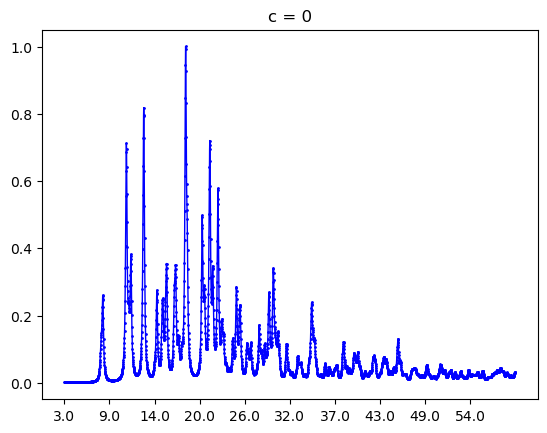

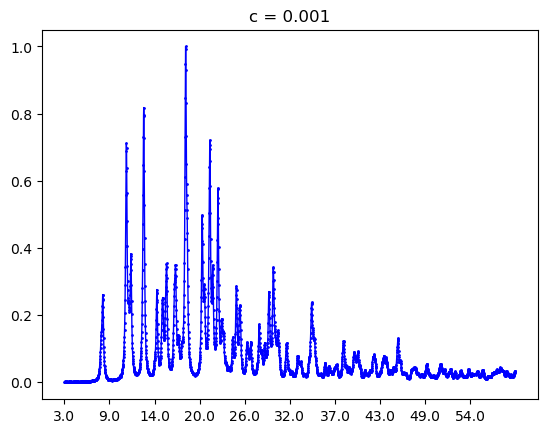

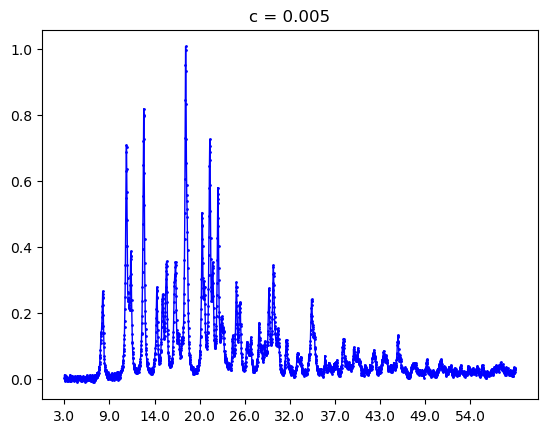

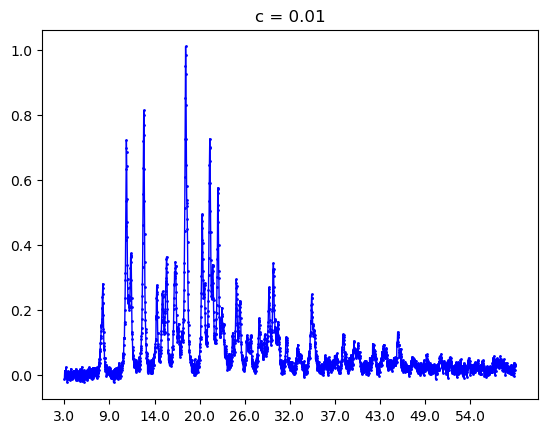

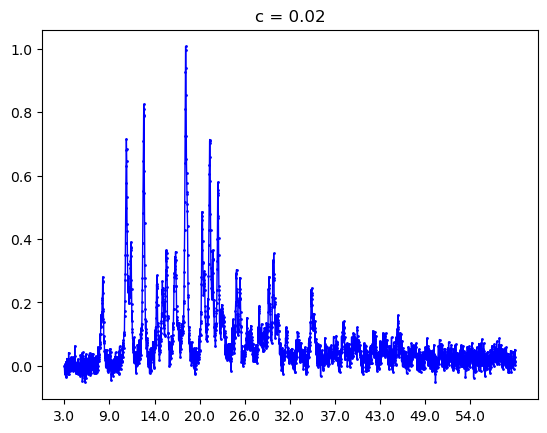

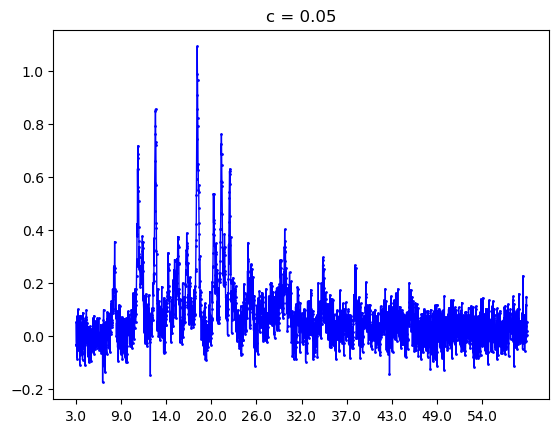

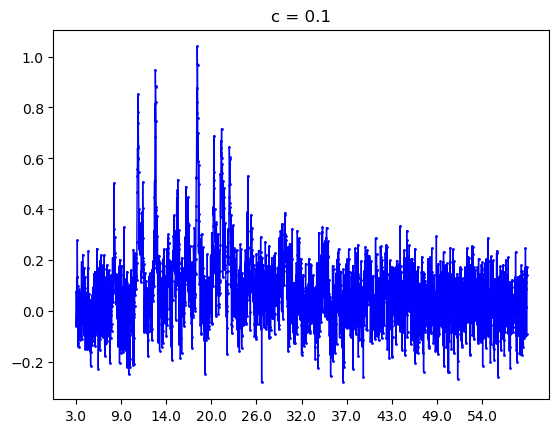

In [5]:
om = 11
for c in [0, 1e-3, 5e-3, 1e-2, 2.e-2, 5e-2, 1e-1]:
    plt.figure()
    plt.title(f"c = {c}")
    
    attack_xrd = xrd[om,:,0] + np.random.normal(loc=0, scale = c, size=2780)*adv_attack[om,:,0]
    plt.scatter(np.arange(2780), attack_xrd, s=1, color='blue')
    plt.plot(np.arange(2780), attack_xrd, linewidth=1, color='blue')
    plt.xticks(np.arange(0, 2780, 2780/10), 
               np.round(np.linspace(3, 60, 2780)[np.arange(0, 2780, 2780/10).astype(int)]))
    
    plt.show()

As you can see, the quality degradation done by the adversarial attack serves as an strategy for data augmentation.

<Figure size 640x480 with 0 Axes>

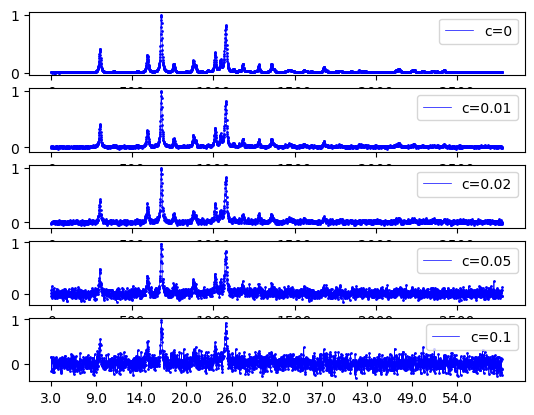

In [6]:
om = 1

plt.figure()
fig, axs = plt.subplots(5,1)
for n,c in enumerate([0, 1e-2, 2.e-2, 5e-2, 1e-1]):

    attack_xrd = xrd[om,:,0] + np.random.normal(loc=0, scale = c, size=2780)*adv_attack[om,:,0]
    axs[n].scatter(np.arange(2780), attack_xrd, s=1, color='blue')
    axs[n].plot(np.arange(2780), attack_xrd, linewidth=0.5, color='blue', label=f"c={c}")
    axs[n].legend(loc='best')
    
plt.xticks(np.arange(0, 2780, 2780/10), 
           np.round(np.linspace(3, 60, 2780)[np.arange(0, 2780, 2780/10).astype(int)]))
plt.show()

Now, we compute the direction of the gradients of all the samples in the test set.

In [7]:
batch_size = 128
batches = np.arange(0, xrd.shape[0], batch_size)

In [8]:
adv_attacks = np.zeros(xrd.shape)
for n,_ in enumerate(batches):
    
    if n != batches.shape[0]-1:
        adv_attack = create_adversarial_pattern(xrd[batches[n]:batches[n+1]], binformula[batches[n]:batches[n+1]], y[batches[n]:batches[n+1]])
        adv_attacks[batches[n]:batches[n+1]] = adv_attack
    else:
        adv_attack = create_adversarial_pattern(xrd[batches[n]:], binformula[batches[n]:], y[batches[n]:])
        adv_attacks[batches[n]:] = adv_attack
                                                                                             
    print(n+1, '/', batches.shape[0])

1 / 121
2 / 121
3 / 121
4 / 121
5 / 121
6 / 121
7 / 121
8 / 121
9 / 121
10 / 121
11 / 121
12 / 121
13 / 121
14 / 121
15 / 121
16 / 121
17 / 121
18 / 121
19 / 121
20 / 121
21 / 121
22 / 121
23 / 121
24 / 121
25 / 121
26 / 121
27 / 121
28 / 121
29 / 121
30 / 121
31 / 121
32 / 121
33 / 121
34 / 121
35 / 121
36 / 121
37 / 121
38 / 121
39 / 121
40 / 121
41 / 121
42 / 121
43 / 121
44 / 121
45 / 121
46 / 121
47 / 121
48 / 121
49 / 121
50 / 121
51 / 121
52 / 121
53 / 121
54 / 121
55 / 121
56 / 121
57 / 121
58 / 121
59 / 121
60 / 121
61 / 121
62 / 121
63 / 121
64 / 121
65 / 121
66 / 121
67 / 121
68 / 121
69 / 121
70 / 121
71 / 121
72 / 121
73 / 121
74 / 121
75 / 121
76 / 121
77 / 121
78 / 121
79 / 121
80 / 121
81 / 121
82 / 121
83 / 121
84 / 121
85 / 121
86 / 121
87 / 121
88 / 121
89 / 121
90 / 121
91 / 121
92 / 121
93 / 121
94 / 121
95 / 121
96 / 121
97 / 121
98 / 121
99 / 121
100 / 121
101 / 121
102 / 121
103 / 121
104 / 121
105 / 121
106 / 121
107 / 121
108 / 121
109 / 121
110 / 121
111 / 12

In the next cell, we calculate the mean of the cosine similarity between the modified diffraction patterns with the adversarial attack and the original diffraction patterns.

In [9]:
latpar_noise = dict()
for n,c in enumerate([0, 1e-3, 5e-3, 1e-2, 2.5e-2, 5e-2, 1e-1]):
    np.random.seed(10)
    noise_xrd = xrd + np.random.normal(loc=0, scale = c, size=xrd.shape)*adv_attacks
    print(f"mean cosine similarity:{np.diagonal(sklearn.metrics.pairwise.cosine_similarity(xrd[:,:,0], noise_xrd[:,:,0])).mean()}")
    latpar_noise[n] = baseModel.predict([noise_xrd, binformula])

mean cosine similarity:1.0
483/483 [==============================] - 18s 31ms/step
mean cosine similarity:0.9999491304347181
483/483 [==============================] - 15s 32ms/step
mean cosine similarity:0.9987311588287112
483/483 [==============================] - 16s 34ms/step
mean cosine similarity:0.9949605053001989
483/483 [==============================] - 15s 32ms/step
mean cosine similarity:0.9699641585757056
483/483 [==============================] - 18s 36ms/step
mean cosine similarity:0.8961230952831286
483/483 [==============================] - 17s 36ms/step
mean cosine similarity:0.7193976624627221
483/483 [==============================] - 15s 31ms/step


We compare the actual vs. predicted lattice parameters using the diffraction patterns after the adversarial attack. You can observe that using a small normally-distributed noise as low $\sigma$ = 0.001 diminishes the predictive performance of the base model.

0: 1.0002337012525577


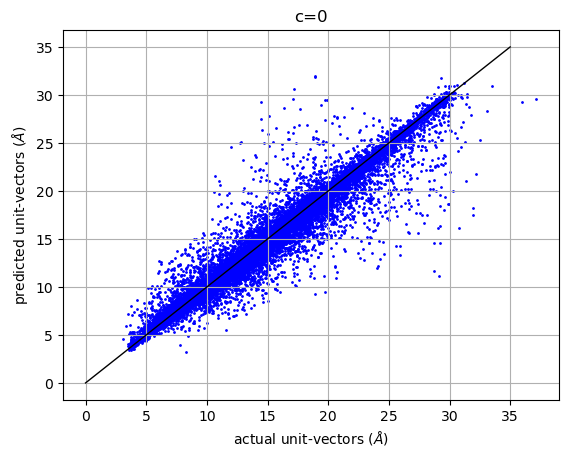

1: 2.2110979782081026


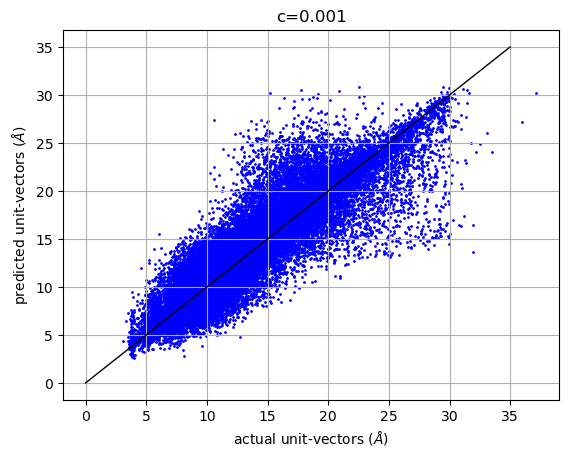

2: 2.7180795708195786


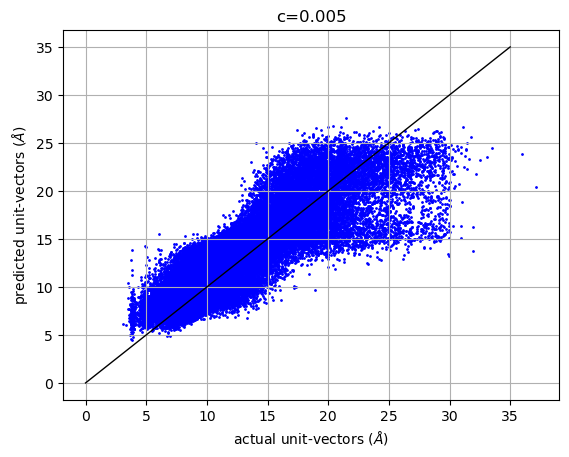

3: 2.767675553075745


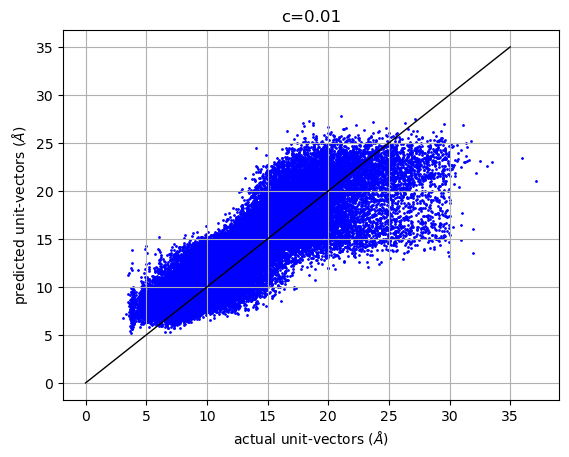

4: 2.85078498722341


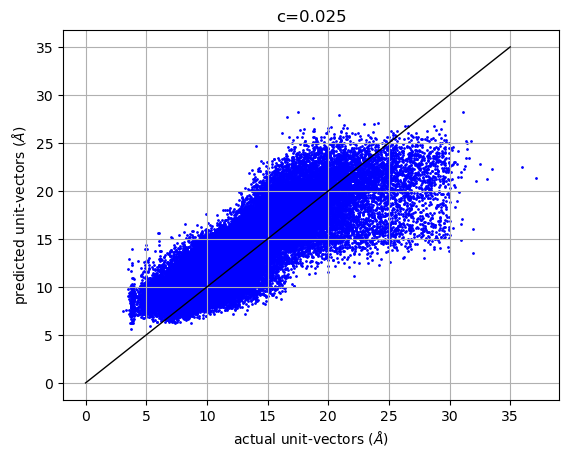

5: 2.913058948808396


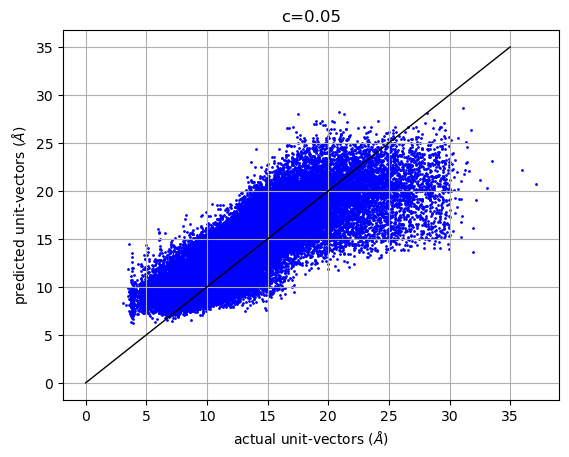

6: 2.93164568110029


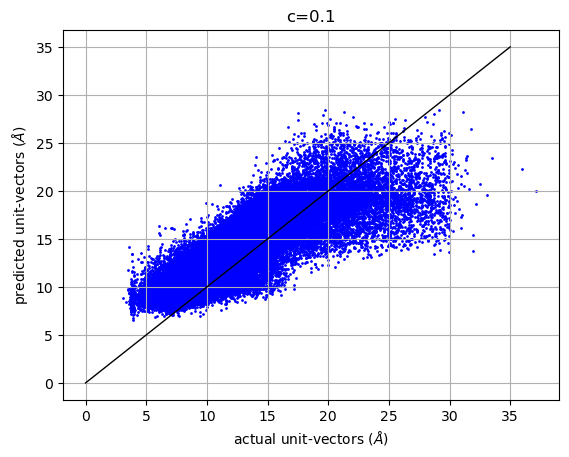

In [10]:
for n,c in enumerate([0, 1e-3, 5e-3, 1e-2, 2.5e-2, 5e-2, 1e-1]):
    
    rmse = np.mean((latpar_noise[n][:,:3] - y[:,:3])**2)**0.5
    print(f"{n}: {rmse}")
    
    plt.figure()
    plt.title(f"c={c}")
    plt.scatter(y[:,:3], latpar_noise[n][:,:3], color='blue', s=1)
    plt.grid(True)
    plt.plot(np.arange(0,40,5), np.arange(0,40,5), color='black', linewidth=1)
    plt.xlabel('actual unit-vectors ($\AA$)')
    plt.ylabel('predicted unit-vectors ($\AA$)')
    plt.show()

With the augmented data by adversarial attack:
 - We can fine-tune the current base model.
 - We can train a new model.

**References:**
    
1. [Explaining and Harnessing Adversarial Examples](https://arxiv.org/pdf/1412.6572)
2. [Adversarial example using FGSM](https://www.tensorflow.org/tutorials/generative/adversarial_fgsm)